In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Setup complete. Using torch {torch.__version__}({device})")
torch.manual_seed(42)
lookback = 30
PATH = os.path.join(os.getcwd(),"models","{}daysLoopback".format(lookback),"btc5y")


Setup complete. Using torch 2.0.1+cu117(cuda)


In [13]:
btc = yf.Ticker("BTC-USD")
historico_btc = btc.history(period="5y")
print(historico_btc)

                                   Open          High           Low  \
Date                                                                  
2018-10-17 00:00:00+00:00   6590.520020   6601.209961   6517.450195   
2018-10-18 00:00:00+00:00   6542.330078   6567.540039   6450.040039   
2018-10-19 00:00:00+00:00   6478.069824   6493.680176   6445.310059   
2018-10-20 00:00:00+00:00   6460.919922   6497.720215   6449.000000   
2018-10-21 00:00:00+00:00   6490.089844   6556.379883   6476.000000   
...                                 ...           ...           ...   
2023-10-13 00:00:00+00:00  26752.878906  27092.697266  26686.322266   
2023-10-14 00:00:00+00:00  26866.203125  26969.000000  26814.585938   
2023-10-15 00:00:00+00:00  26858.011719  27289.169922  26817.894531   
2023-10-16 00:00:00+00:00  27162.628906  29448.138672  27130.472656   
2023-10-17 00:00:00+00:00  28540.667969  28604.316406  28130.132812   

                                  Close       Volume  Dividends  Stock Split

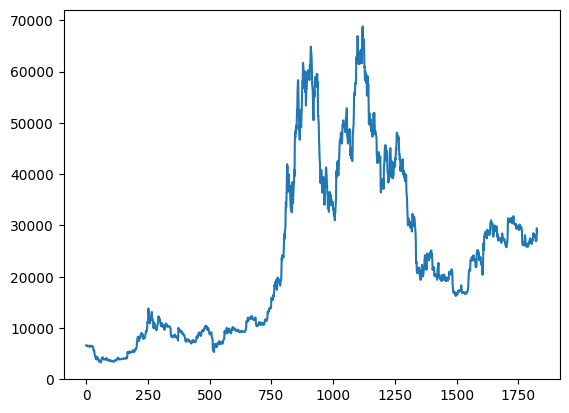

In [14]:
stock_price = historico_btc.iloc[:,1:2].values.astype('float32')
stock_price = stock_price.reshape((-1,1))

plt.plot(stock_price)
plt.show()


Min:  3275.378
Max:  68789.625


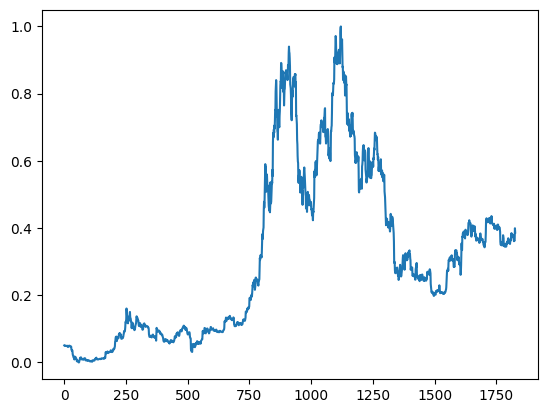

In [15]:
sc = MinMaxScaler(feature_range=(0,1))
full_min = stock_price.min()
full_max = stock_price.max()
sc_full = MinMaxScaler(feature_range=(full_min, full_max))
training_set_scaled = sc.fit_transform(stock_price)
# training_set_scaled = stock_price
print("Min: ",stock_price.min())
print("Max: ", stock_price.max())
plt.plot(training_set_scaled)
plt.show()

In [16]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback:i+lookback+1]
        X.append(feature)
        y.append(target)
    
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))
def create_single_sample(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    feature = dataset[0:lookback]
    target = dataset[1:lookback]
    X.append(feature)
    y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))
def get_single_sample(dataset, lookback, pos):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    
    feature = dataset[pos:pos+lookback]
    target = dataset[pos+1:pos+lookback+1]
    X.append(feature)
    y.append(target)
        
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))
# train-val split for time series
train_size = int(len(training_set_scaled) * 0.67)
val_size = len(training_set_scaled) - train_size
train, val = training_set_scaled[:train_size], training_set_scaled[train_size:]
X_train, y_train = create_dataset(train, lookback=lookback)
X_val, y_val = create_dataset(val, lookback=lookback)
X_full, y_full = create_single_sample(training_set_scaled, lookback=lookback)
train_min = stock_price[:train_size,:].min()
train_max = stock_price[:train_size,:].max()
val_min = stock_price[train_size:,:].min()
val_max = stock_price[train_size:,:].max()
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print("train Min: ",stock_price[:train_size,:].min())
print("val Min: ",stock_price[train_size:,:].min())
print("train max: ",stock_price[:train_size,:].max())
print("val max: ",stock_price[train_size:,:].max())
sc_train = MinMaxScaler(feature_range=(train_min, train_max))
sc_val = MinMaxScaler(feature_range=(val_min, val_max))



torch.Size([1194, 30, 1]) torch.Size([1194, 1, 1])
torch.Size([573, 30, 1]) torch.Size([573, 1, 1])
train Min:  3275.378
val Min:  16253.048
train max:  68789.625
val max:  48086.836


In [27]:
class LSTMOnlyLast(nn.Module):
    def __init__(self,hidden_size=50, num_layers=1, dropout = 0):
        super().__init__()
        self.hidden_size = hidden_size
        if num_layers ==1:
            dropout=0
        self.lstm_0 = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        x, _ = self.lstm_0(x,(h_0,c_0))
        x = x[:, -1, :]
        x = self.linear(x)
        return x
class LSTMWhole(nn.Module):
    def __init__(self,hidden_size=50, num_layers=1, dropout = 0):
        super().__init__()
        self.hidden_size = hidden_size
        if num_layers ==1:
            dropout=0
        self.lstm_0 = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(1, batch_size, self.hidden_size).to(device)
        x, _ = self.lstm_0(x,(h_0,c_0))
        x = self.linear(x)
        return x

In [19]:
model = LSTMOnlyLast(20,1,0).to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1861


  0%|          | 0/2000 [00:00<?, ?it/s]

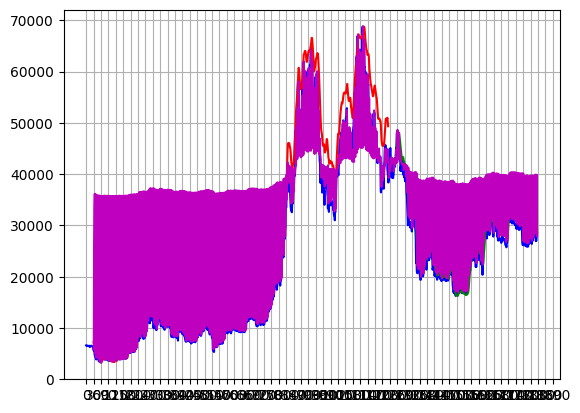

  0%|          | 1/2000 [00:03<1:52:48,  3.39s/it]

New Best model saved
Epoch 0: train RMSE 0.3715, val RMSE 0.2304, best val 0.2304


  5%|▌         | 100/2000 [00:40<11:17,  2.80it/s]

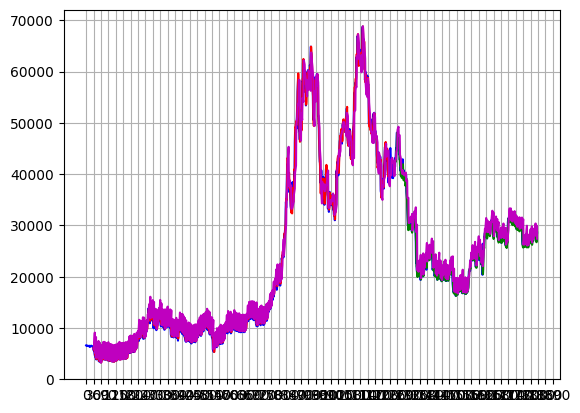

  5%|▌         | 101/2000 [00:43<30:18,  1.04it/s]

New Best model saved
Epoch 100: train RMSE 0.0285, val RMSE 0.0214, best val 0.0214


 10%|█         | 200/2000 [01:21<12:34,  2.39it/s]

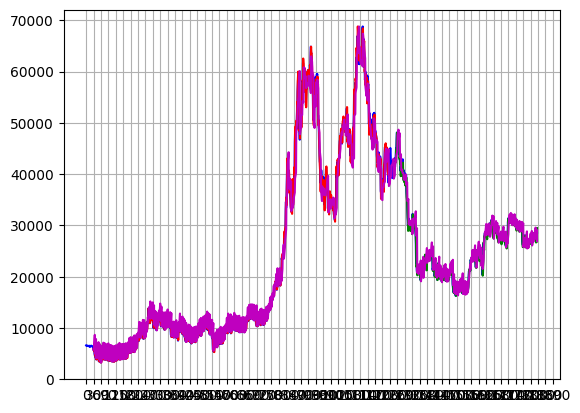

 10%|█         | 201/2000 [01:24<33:19,  1.11s/it]

New Best model saved
Epoch 200: train RMSE 0.0236, val RMSE 0.0171, best val 0.0171


 15%|█▌        | 300/2000 [02:03<10:52,  2.61it/s]

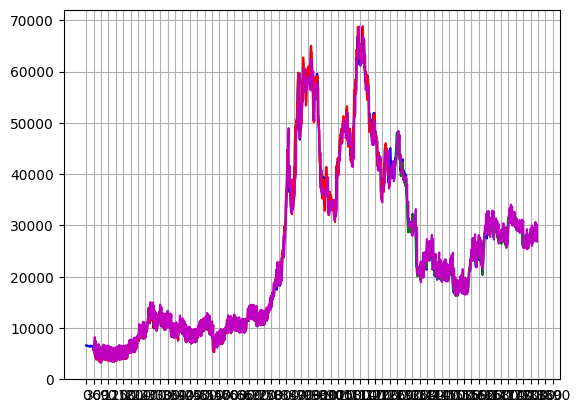

 15%|█▌        | 301/2000 [02:06<31:51,  1.12s/it]

Epoch 300: train RMSE 0.0229, val RMSE 0.0225, best val 0.0171


 20%|██        | 400/2000 [02:44<09:57,  2.68it/s]

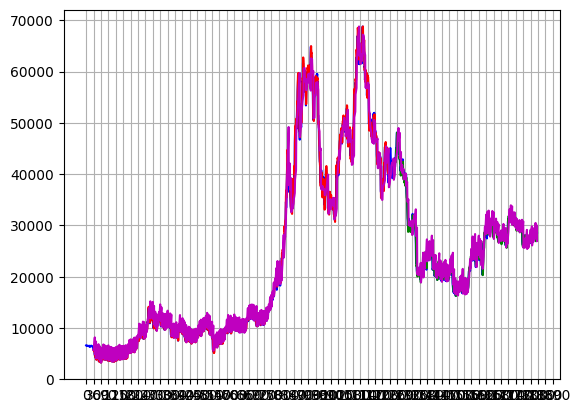

 20%|██        | 401/2000 [02:47<27:13,  1.02s/it]

Epoch 400: train RMSE 0.0223, val RMSE 0.0212, best val 0.0171


 25%|██▌       | 500/2000 [03:23<08:36,  2.91it/s]

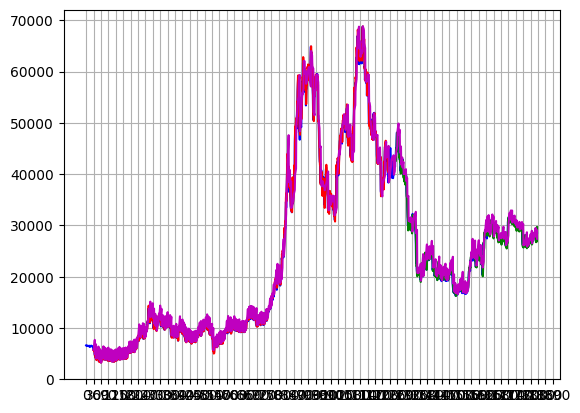

 25%|██▌       | 501/2000 [03:26<23:33,  1.06it/s]

New Best model saved
Epoch 500: train RMSE 0.0191, val RMSE 0.0150, best val 0.0150


 30%|███       | 600/2000 [04:02<09:16,  2.52it/s]

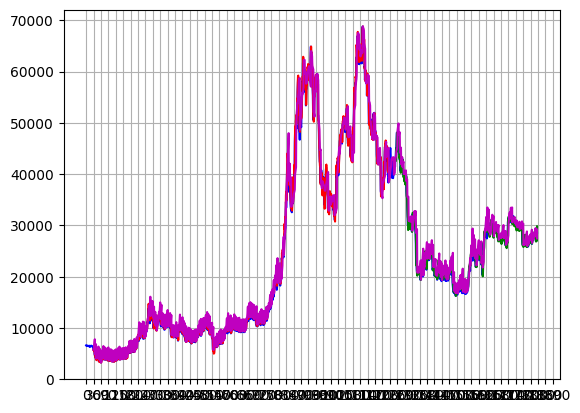

 30%|███       | 601/2000 [04:05<25:51,  1.11s/it]

Epoch 600: train RMSE 0.0198, val RMSE 0.0166, best val 0.0150


 35%|███▌      | 700/2000 [04:40<07:28,  2.90it/s]

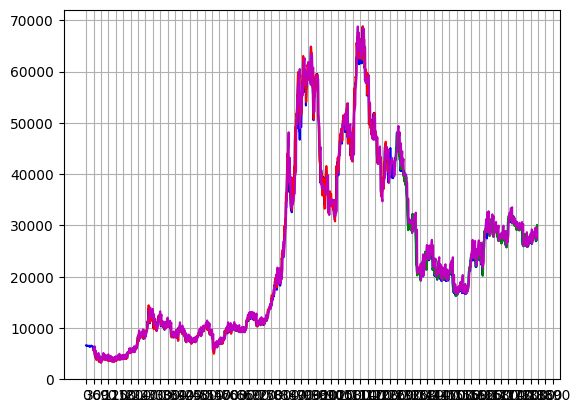

 35%|███▌      | 701/2000 [04:43<25:10,  1.16s/it]

Epoch 700: train RMSE 0.0170, val RMSE 0.0153, best val 0.0150


 40%|████      | 800/2000 [05:22<07:28,  2.68it/s]

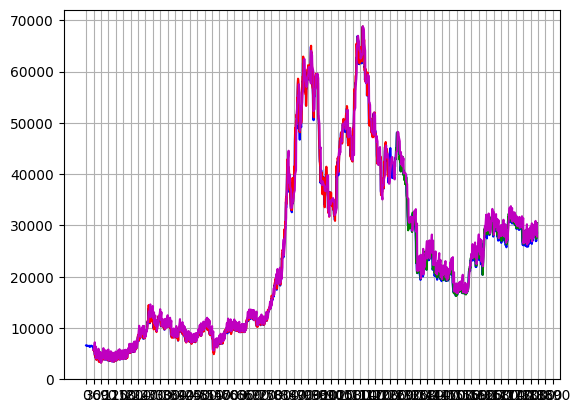

 40%|████      | 801/2000 [05:25<21:53,  1.10s/it]

Epoch 800: train RMSE 0.0166, val RMSE 0.0181, best val 0.0150


 45%|████▌     | 900/2000 [06:03<06:54,  2.66it/s]

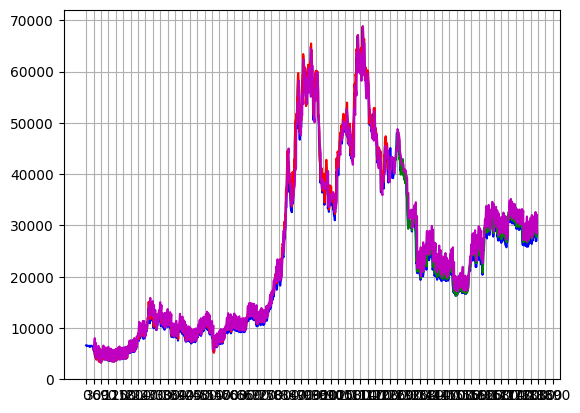

 45%|████▌     | 901/2000 [06:06<19:28,  1.06s/it]

Epoch 900: train RMSE 0.0215, val RMSE 0.0245, best val 0.0150


 46%|████▌     | 911/2000 [06:10<07:23,  2.46it/s]


KeyboardInterrupt: 

In [21]:
optimizer = optim.Adam(model.parameters(),lr=0.0005)
loss_fn = nn.MSELoss()
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)
val_loader = data.DataLoader(data.TensorDataset(X_val, y_val), shuffle=False, batch_size=8)
n_epochs = 2000
best_loss = 100
y_full_preds = np.ones((training_set_scaled.shape[0]-lookback,1))*np.nan
for epoch in tqdm(range(n_epochs)):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(torch.unsqueeze(y_pred, dim=-1), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            for pred in range(training_set_scaled.shape[0]-lookback):
                X_full_gpu = X_full.to(device)
                y_pred_full = model(X_full_gpu)
                y_pred_noise = (y_pred_full + X_full_gpu[:,-1,:])/2
                # y_pred_noise = y_pred_full
                # y_full_preds[pred,:] = torch.unsqueeze(y_pred_full.cpu(), dim=-1)[:, -1, :]
                y_full_preds[pred,:] = torch.unsqueeze(y_pred_noise.cpu(), dim=-1)[:, -1, :]
                new_input = np.ones_like(X_full.numpy())
                new_input[:,:-1,:] = X_full.numpy()[:,1:,:]
                # new_input[:,-1,:] = torch.unsqueeze(y_pred_full.cpu(), dim=-1)[:, -1, :]
                new_input[:,-1,:] = torch.unsqueeze(y_pred_noise.cpu(), dim=-1)[:, -1, :]
                X_full = torch.tensor(new_input)
                full_test_plot = np.ones((training_set_scaled.shape[0],1)) * np.nan
                full_test_plot[lookback:] = sc_full.fit_transform(y_full_preds.reshape(-1,1))
                # full_test_plot[lookback:] = y_full_preds.reshape(-1,1)
                if pred % 5 == 0:
                    X_samp, y_samp = get_single_sample(training_set_scaled, lookback, pred)
                    # X_full = (X_full + X_samp)/2
                    X_full = (X_samp)

            X_full, y_full = create_single_sample(train, lookback=lookback)
            X_train_gpu = X_train.to(device)
            X_val_gpu = X_val.to(device)
            y_pred_train = model(X_train_gpu)
            train_rmse = np.sqrt(loss_fn(torch.unsqueeze(y_pred_train.cpu(), dim=-1), y_train))
            y_pred_val = model(X_val_gpu)
            val_rmse = np.sqrt(loss_fn(torch.unsqueeze(y_pred_val.cpu(), dim=-1), y_val))
            # shift train predictions for plotting
            train_plot = np.ones_like(training_set_scaled) * np.nan
            # train_plot[lookback:train_size] = sc_train.fit_transform(y_pred_train.cpu()[:, -1, :])
            # train_plot[lookback:train_size] = y_pred_train.cpu()[:, -1, :]
            train_plot[lookback:train_size] = sc_train.fit_transform(torch.unsqueeze(y_pred_train.cpu(), dim=-1)[:, -1, :])
            # train_plot[lookback:train_size] = torch.unsqueeze(y_pred_train.cpu(), dim=-1)[:, -1, :]
            # shift val predictions for plotting
            val_plot = np.ones_like(training_set_scaled) * np.nan
            # val_plot[train_size+lookback:len(training_set_scaled)] = sc_val.fit_transform(y_pred_val.cpu()[:, -1, :])
            val_plot[train_size+lookback:len(training_set_scaled)] = sc_val.fit_transform(torch.unsqueeze(y_pred_val.cpu(), dim=-1)[:, -1, :])
            # val_plot[train_size+lookback:len(training_set_scaled)] = torch.unsqueeze(y_pred_val.cpu(), dim=-1)[:, -1, :]
            # plot
            fig, ax = plt.subplots()
            ax.plot(stock_price, c='b')
            ax.plot(train_plot, c='r')
            ax.plot(val_plot, c='g')
            ax.plot(full_test_plot,c='m')
            start, end = ax.get_xlim()
            ax.xaxis.set_ticks(np.arange(0, end, 30))
            ax.grid()
            plt.show()
            if val_rmse < best_loss:
                best_loss = val_rmse
                try:
                    torch.save(model.state_dict(), os.path.join(PATH,"best_model.pt"))
                except:
                    os.makedirs(PATH)
                    torch.save(model.state_dict(), os.path.join(PATH,"best_model.pt"))

                print("New Best model saved")


        print("Epoch %d: train RMSE %.4f, val RMSE %.4f, best val %.4f" % (epoch, train_rmse, val_rmse, best_loss))

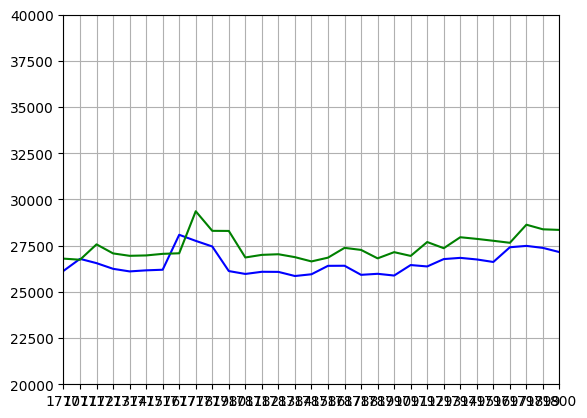

In [26]:
fig, ax = plt.subplots()
ax.plot(stock_price, c='b')
ax.plot(train_plot, c='r')
ax.plot(val_plot, c='g')
# ax.plot(full_test_plot,c='m')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 1))
ax.grid()
plt.xlim(1770,1800)
plt.ylim(20000,40000)
plt.show()

# Predicción de valores futuros

In [32]:
btc = yf.Ticker("BTC-USD")
historico_btc = btc.history(period="5y")
stock_price = historico_btc.iloc[:,1:2].values.astype('float32')
stock_price = stock_price.reshape((-1,1))
sc = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc.fit_transform(stock_price)


def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

def create_single_sample(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    feature = dataset[0:lookback]
    target = dataset[1:lookback+1]
    X.append(feature)
    y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))
    

def create_testset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X = []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        X.append(feature)
    
    return torch.tensor(np.array(X))

train_size = int(len(test_set_scaled) * 0.67)
val_size = len(test_set_scaled) - train_size
train, val = test_set_scaled[:train_size], test_set_scaled[train_size:]
lookback = 30
X_val, y_val = create_dataset(val, lookback=lookback)
X_val_test, y_val_test = create_single_sample(val, lookback=lookback)
X_full, y_full = create_single_sample(train, lookback=lookback)
val_min = stock_price[train_size:,:].min()
val_max = stock_price[train_size:,:].max()
sc_val = MinMaxScaler(feature_range=(val_min, val_max))
test = test_set_scaled[-lookback-1:]
X_test = create_testset(test, lookback=lookback)
print(X_test.shape)
test_min = stock_price[-lookback:,:].min()
test_max = stock_price[-lookback:,:].max()
sc_test = MinMaxScaler(feature_range=(test_min, test_max))

torch.Size([1, 30, 1])


In [38]:
model = LSTMOnlyLast(20,1,0).to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

1861


In [39]:
epoch = 300
model_path = PATH = os.path.join(os.getcwd(),"models","{}daysLoopback".format(lookback),"btc5y", "btc_pred_500_epoch.pt")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
n_preds = 31
y_preds = np.ones((n_preds,1))*np.nan
y_val_preds = np.ones((val_size-lookback,1))*np.nan
y_full_preds = np.ones((test_set_scaled.shape[0]-lookback,1))*np.nan

with torch.no_grad():
    X_val_gpu = X_val.to(device)
    y_pred_val = model(X_val_gpu)
    val_plot = np.ones_like(test_set_scaled) * np.nan
    val_plot[train_size+lookback:len(test_set_scaled)] = y_pred_val.cpu()[:, -1, :]
    for pred in range(test_set_scaled.shape[0]-lookback):
        X_full_gpu = X_full.to(device)
        y_pred_full = model(X_full_gpu)
        y_full_preds[pred,:] = y_pred_full.cpu()[:, -1, :]
        new_input = np.ones_like(X_full.numpy())
        new_input[:,:-1,:] = X_full.numpy()[:,1:,:]
        new_input[:,-1,:] = y_pred_full.cpu()[:, -1, :]
        X_full = torch.tensor(new_input)
        full_test_plot = np.ones((test_set_scaled.shape[0],1)) * np.nan
        full_test_plot[lookback:] = y_full_preds.reshape(-1,1)
    for val_pred in range(val_size-lookback):
        X_val_test_gpu = X_val_test.to(device)
        y_pred_val_test = model(X_val_test_gpu)
        y_val_preds[val_pred,:] = y_pred_val_test.cpu()[:, -1, :]
        new_input = np.ones_like(X_val_test.numpy())
        new_input[:,:-1,:] = X_val_test.numpy()[:,1:,:]
        new_input[:,-1,:] = y_pred_val_test.cpu()[:, -1, :]
        X_val_test = torch.tensor(new_input)
        val_test_plot = np.ones((test_set_scaled.shape[0],1)) * np.nan
        val_test_plot[train_size+lookback:] = y_val_preds.reshape(-1,1)
    for n_pred in range(n_preds):
        X_test_gpu = X_test.to(device)
        y_pred_test = model(X_test_gpu)
        y_preds[n_pred,:] = y_pred_test.cpu()[:, -1, :]
        new_input = np.ones_like(X_test.numpy())
        new_input[:,:-1,:] = X_test.numpy()[:,1:,:]
        new_input[:,-1,:] = y_pred_test.cpu()[:, -1, :]
        X_test = torch.tensor(new_input)
        test_plot = np.ones((test_set_scaled.shape[0]+n_preds,1)) * np.nan
        test_plot[len(test_set_scaled):len(test_set_scaled)+n_preds] = y_preds.reshape(-1,1)
        # plot
plt.plot(test_set_scaled, c='b')
plt.plot(val_plot,c='g')
plt.plot(val_test_plot,c='r')
plt.plot(test_plot, c='g')
plt.plot(full_test_plot,c='m')
plt.show()

IndexError: too many indices for tensor of dimension 2

NameError: name 'val_test_plot' is not defined

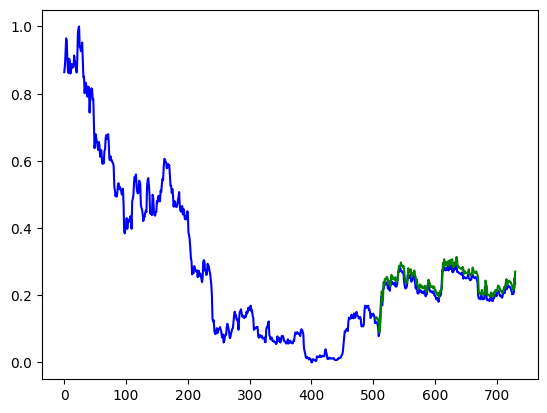

In [10]:
plt.plot(test_set_scaled, c='b')
plt.plot(val_plot,c='g')
plt.plot(val_test_plot,c='r')
plt.plot(test_plot, c='g')
plt.xlim((500,600))
plt.show()